# Bayesian Optimizer using Gaussian Process

In [1]:
import time
t1 = time.time()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

2021-11-03 04:09:52.878724: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2021-11-03 04:09:52.878750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.models import load_model

In [4]:
# Python package scikit-optimize (or skopt) for finding the best choices of these hyper-parameters.
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

## Hyper-Parameters
1. The learning-rate

2. The number of fully-connected / dense layers.

3. The number of nodes for each of the dense layers.

4. Activation function('sigmoid' or 'relu').

5. Batch Size

6. Optimizer 


In [5]:
# search-ranges for hyper-parqameter
batch_size = 128
range_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
range_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
range_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
activation_function = Categorical(categories=['relu', 'sigmoid'], name='activation')

dimensions = [range_learning_rate, range_num_dense_layers, range_num_dense_nodes, activation_function]

In [6]:
default_parameters = [1e-5, 1, 16, 'relu']

In [7]:
# log the training-progress for all parameter-combinations
def log_dir_name(learning_rate, num_dense_layers, num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"
    
    log_dir = s.format(learning_rate, num_dense_layers, 
                       num_dense_nodes, activation)
    return log_dir

## Load MNIST Dataset

70.000 images and class-numbers for the images.
- Training-set:		48999
- Validation-set:	14000
- Test-set:		7001

In [8]:
from sklearn.model_selection import train_test_split
DATASET_SIZE = 70000
TRAIN_RATIO = 5/7
VALIDATION_RATIO = (1-5/7)/4
TEST_RATIO = ((1-5/7)/4)*3
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((60000,784)).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train)

x_test = x_test.reshape((10000,784)).astype('float32') / 255.0
y_test = tf.keras.utils.to_categorical(y_test)

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

print('Training data: {}. {}'.format(x_train.shape, y_train.shape))
print('Validation data: {}. {}'.format(x_val.shape, y_val.shape))
print('Test data: {}. {}'.format(x_test.shape, y_test.shape))

Training data: (50000, 784). (50000, 10)
Validation data: (5000, 784). (5000, 10)
Test data: (15000, 784). (15000, 10)


In [9]:
img_size = 28
img_size_flat = 784
img_shape = (28, 28)
img_shape_full = (28, 28, 1)
num_classes = 10
num_channels = 1
validation_data = (x_val, y_val) 

## Helper-function for plotting images

In [10]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

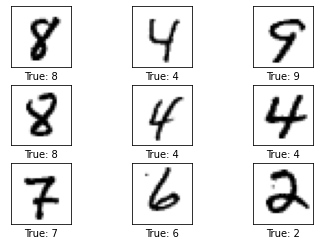

In [11]:
y_test_cls = [np.argmax(y, axis=None, out=None) for y in y_test]
images = x_test[0:9]
cls_true = y_test_cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [12]:
def plot_example_errors(cls_pred):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## Hyper-Parameter Optimization

In [13]:
def create_model(learning_rate, num_dense_layers, num_dense_nodes, activation):
    
    model = Sequential()
    # Add fully-connected / dense layers.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes, activation=activation, name=name))
    # Last fully-connected / dense layer with softmax-activation
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(learning_rate=learning_rate)
    #optimizer = sel_optimizer(learning_rate=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

path_best_model = 'best_trained_model.h5'
best_accuracy = 0.0

In [14]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation):
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate, num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes, activation=activation)


    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers, 
                           num_dense_nodes, activation)

    # saves the log-files for TensorBoard.
    callback_log = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True,
                               write_grads=False, write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=x_train, y=y_train, 
                        epochs=3, batch_size=batch_size, 
                        validation_data=validation_data, 
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    accuracy = history.history['val_accuracy'][-1]
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the new model
    global best_accuracy
    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    K.clear_session()
    return -accuracy

## Run Test for default hyper parameters

In [15]:
fitness(x=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu



2021-11-03 04:09:55.551532: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2021-11-03 04:09:55.551551: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-03 04:09:55.551585: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ECE-util1): /proc/driver/nvidia/version does not exist
2021-11-03 04:09:55.551802: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with t

Epoch 1/3
  1/391 [..............................] - ETA: 0s - loss: 2.4781 - accuracy: 0.0625WARNING:tensorflow:From /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 50/391 [==>...........................] - ETA: 1s - loss: 2.4036 - accuracy: 0.0870

2021-11-03 04:09:56.135169: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:09:56.157768: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_56
2021-11-03 04:09:56.162438: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_56/ECE-util1.trace.json.gz
2021-11-03 04:09:56.174598: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_56
2021-11-03 04:09:56.178157: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_56/ECE-util1.memory_profile.json.gz
2021-11-03 04:09:56.

391/391 [==============================] - 1s 3ms/step - loss: 2.3275 - accuracy: 0.1194 - val_loss: 2.2584 - val_accuracy: 0.1498
Epoch 2/3
391/391 [==============================] - 1s 2ms/step - loss: 2.1879 - accuracy: 0.2027 - val_loss: 2.1169 - val_accuracy: 0.2602
Epoch 3/3
391/391 [==============================] - 1s 2ms/step - loss: 2.0455 - accuracy: 0.3232 - val_loss: 1.9716 - val_accuracy: 0.3914

Accuracy: 39.14%



-0.391400009393692

## Run the Hyper-Parameter Optimization

In [16]:
%%time
search_result = gp_minimize(func=fitness, dimensions=dimensions, 
                            acq_func='EI', # Expected Improvement.
                            n_calls=15, x0=default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3


2021-11-03 04:09:58.847834: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 47/391 [==>...........................] - ETA: 1s - loss: 2.2919 - accuracy: 0.1775

2021-11-03 04:09:59.249194: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:09:59.284133: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_59
2021-11-03 04:09:59.288608: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_59/ECE-util1.trace.json.gz
2021-11-03 04:09:59.297319: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_59
2021-11-03 04:09:59.300085: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_1e-05_layers_1_nodes_16_relu/train/plugins/profile/2021_11_03_04_09_59/ECE-util1.memory_profile.json.gz
2021-11-03 04:09:59.

391/391 [==============================] - 1s 3ms/step - loss: 2.2496 - accuracy: 0.2187 - val_loss: 2.1919 - val_accuracy: 0.2870
Epoch 2/3
391/391 [==============================] - 1s 2ms/step - loss: 2.1374 - accuracy: 0.3378 - val_loss: 2.0718 - val_accuracy: 0.3848
Epoch 3/3
391/391 [==============================] - 1s 2ms/step - loss: 2.0182 - accuracy: 0.4170 - val_loss: 1.9517 - val_accuracy: 0.4596

Accuracy: 45.96%

learning rate: 2.5e-03
num_dense_layers: 2
num_dense_nodes: 481
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:01.906694: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 32/391 [=>............................] - ETA: 1s - loss: 1.6477 - accuracy: 0.5032

2021-11-03 04:10:02.487472: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:02.524341: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_2_nodes_481_sigmoid/train/plugins/profile/2021_11_03_04_10_02
2021-11-03 04:10:02.527336: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-03_layers_2_nodes_481_sigmoid/train/plugins/profile/2021_11_03_04_10_02/ECE-util1.trace.json.gz
2021-11-03 04:10:02.533561: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_2_nodes_481_sigmoid/train/plugins/profile/2021_11_03_04_10_02
2021-11-03 04:10:02.535427: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-03_layers_2_nodes_481_sigmoid/train/plugins/profile/2021_11_03_04_10_02/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 4ms/step - loss: 0.4100 - accuracy: 0.8762 - val_loss: 0.2273 - val_accuracy: 0.9292
Epoch 2/3
391/391 [==============================] - 1s 3ms/step - loss: 0.1529 - accuracy: 0.9539 - val_loss: 0.1405 - val_accuracy: 0.9570
Epoch 3/3
391/391 [==============================] - 1s 3ms/step - loss: 0.0971 - accuracy: 0.9699 - val_loss: 0.1084 - val_accuracy: 0.9654

Accuracy: 96.54%

learning rate: 6.7e-05
num_dense_layers: 3
num_dense_nodes: 66
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:06.761435: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 46/391 [==>...........................] - ETA: 1s - loss: 2.4508 - accuracy: 0.1705

2021-11-03 04:10:07.218172: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:07.263500: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_7e-05_layers_3_nodes_66_sigmoid/train/plugins/profile/2021_11_03_04_10_07
2021-11-03 04:10:07.268886: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_7e-05_layers_3_nodes_66_sigmoid/train/plugins/profile/2021_11_03_04_10_07/ECE-util1.trace.json.gz
2021-11-03 04:10:07.279017: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_7e-05_layers_3_nodes_66_sigmoid/train/plugins/profile/2021_11_03_04_10_07
2021-11-03 04:10:07.282362: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_7e-05_layers_3_nodes_66_sigmoid/train/plugins/profile/2021_11_03_04_10_07/ECE-util1.memory_profile.json.gz
2021-11-

391/391 [==============================] - 1s 3ms/step - loss: 2.3169 - accuracy: 0.2151 - val_loss: 2.2425 - val_accuracy: 0.3186
Epoch 2/3
391/391 [==============================] - 1s 3ms/step - loss: 2.1684 - accuracy: 0.3557 - val_loss: 2.0749 - val_accuracy: 0.4042
Epoch 3/3
391/391 [==============================] - 1s 3ms/step - loss: 1.9429 - accuracy: 0.4196 - val_loss: 1.8156 - val_accuracy: 0.4608

Accuracy: 46.08%

learning rate: 3.3e-06
num_dense_layers: 3
num_dense_nodes: 351
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:10.481915: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 24/391 [>.............................] - ETA: 2s - loss: 2.4790 - accuracy: 0.0990

2021-11-03 04:10:10.950322: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:10.994571: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-06_layers_3_nodes_351_sigmoid/train/plugins/profile/2021_11_03_04_10_10
2021-11-03 04:10:10.999095: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_3e-06_layers_3_nodes_351_sigmoid/train/plugins/profile/2021_11_03_04_10_10/ECE-util1.trace.json.gz
2021-11-03 04:10:11.007451: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-06_layers_3_nodes_351_sigmoid/train/plugins/profile/2021_11_03_04_10_10
2021-11-03 04:10:11.009954: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_3e-06_layers_3_nodes_351_sigmoid/train/plugins/profile/2021_11_03_04_10_10/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 4ms/step - loss: 2.3931 - accuracy: 0.1001 - val_loss: 2.3229 - val_accuracy: 0.1046
Epoch 2/3
391/391 [==============================] - 1s 4ms/step - loss: 2.3015 - accuracy: 0.1219 - val_loss: 2.2907 - val_accuracy: 0.1088
Epoch 3/3
391/391 [==============================] - 1s 4ms/step - loss: 2.2853 - accuracy: 0.1140 - val_loss: 2.2816 - val_accuracy: 0.1060

Accuracy: 10.60%

learning rate: 3.8e-05
num_dense_layers: 5
num_dense_nodes: 262
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:15.586122: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 27/391 [=>............................] - ETA: 2s - loss: 2.3963 - accuracy: 0.1056

2021-11-03 04:10:16.111491: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:16.161267: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_4e-05_layers_5_nodes_262_sigmoid/train/plugins/profile/2021_11_03_04_10_16
2021-11-03 04:10:16.164793: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_4e-05_layers_5_nodes_262_sigmoid/train/plugins/profile/2021_11_03_04_10_16/ECE-util1.trace.json.gz
2021-11-03 04:10:16.172349: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_4e-05_layers_5_nodes_262_sigmoid/train/plugins/profile/2021_11_03_04_10_16
2021-11-03 04:10:16.174934: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_4e-05_layers_5_nodes_262_sigmoid/train/plugins/profile/2021_11_03_04_10_16/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 5ms/step - loss: 2.3084 - accuracy: 0.1125 - val_loss: 2.2971 - val_accuracy: 0.1060
Epoch 2/3
391/391 [==============================] - 2s 4ms/step - loss: 2.2587 - accuracy: 0.1908 - val_loss: 2.1270 - val_accuracy: 0.3600
Epoch 3/3
391/391 [==============================] - 2s 4ms/step - loss: 1.8563 - accuracy: 0.3722 - val_loss: 1.6732 - val_accuracy: 0.3702

Accuracy: 37.02%

learning rate: 1.9e-05
num_dense_layers: 2
num_dense_nodes: 15
activation: relu

Epoch 1/3


2021-11-03 04:10:21.276757: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 56/391 [===>..........................] - ETA: 1s - loss: 2.3447 - accuracy: 0.1138

2021-11-03 04:10:21.723298: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:21.762978: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-05_layers_2_nodes_15_relu/train/plugins/profile/2021_11_03_04_10_21
2021-11-03 04:10:21.767715: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-05_layers_2_nodes_15_relu/train/plugins/profile/2021_11_03_04_10_21/ECE-util1.trace.json.gz
2021-11-03 04:10:21.777177: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-05_layers_2_nodes_15_relu/train/plugins/profile/2021_11_03_04_10_21
2021-11-03 04:10:21.780018: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-05_layers_2_nodes_15_relu/train/plugins/profile/2021_11_03_04_10_21/ECE-util1.memory_profile.json.gz
2021-11-03 04:10:21.

391/391 [==============================] - 1s 3ms/step - loss: 2.2885 - accuracy: 0.1300 - val_loss: 2.2236 - val_accuracy: 0.1520
Epoch 2/3
391/391 [==============================] - 1s 2ms/step - loss: 2.1645 - accuracy: 0.1769 - val_loss: 2.1029 - val_accuracy: 0.2062
Epoch 3/3
391/391 [==============================] - 1s 2ms/step - loss: 2.0549 - accuracy: 0.2246 - val_loss: 2.0000 - val_accuracy: 0.2446

Accuracy: 24.46%

learning rate: 2.4e-04
num_dense_layers: 4
num_dense_nodes: 244
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:24.305953: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 24/391 [>.............................] - ETA: 2s - loss: 2.3536 - accuracy: 0.1038

2021-11-03 04:10:24.831166: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:24.875836: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-04_layers_4_nodes_244_sigmoid/train/plugins/profile/2021_11_03_04_10_24
2021-11-03 04:10:24.879437: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-04_layers_4_nodes_244_sigmoid/train/plugins/profile/2021_11_03_04_10_24/ECE-util1.trace.json.gz
2021-11-03 04:10:24.886991: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-04_layers_4_nodes_244_sigmoid/train/plugins/profile/2021_11_03_04_10_24
2021-11-03 04:10:24.889451: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-04_layers_4_nodes_244_sigmoid/train/plugins/profile/2021_11_03_04_10_24/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 5ms/step - loss: 1.6166 - accuracy: 0.4619 - val_loss: 0.8105 - val_accuracy: 0.7660
Epoch 2/3
391/391 [==============================] - 2s 4ms/step - loss: 0.5990 - accuracy: 0.8332 - val_loss: 0.4654 - val_accuracy: 0.8748
Epoch 3/3
391/391 [==============================] - 2s 4ms/step - loss: 0.4080 - accuracy: 0.8850 - val_loss: 0.3759 - val_accuracy: 0.8946

Accuracy: 89.46%

learning rate: 3.2e-03
num_dense_layers: 1
num_dense_nodes: 189
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:29.903576: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 44/391 [==>...........................] - ETA: 1s - loss: 0.9528 - accuracy: 0.7537

2021-11-03 04:10:30.312396: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:30.352919: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-03_layers_1_nodes_189_sigmoid/train/plugins/profile/2021_11_03_04_10_30
2021-11-03 04:10:30.357339: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_3e-03_layers_1_nodes_189_sigmoid/train/plugins/profile/2021_11_03_04_10_30/ECE-util1.trace.json.gz
2021-11-03 04:10:30.365840: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-03_layers_1_nodes_189_sigmoid/train/plugins/profile/2021_11_03_04_10_30
2021-11-03 04:10:30.368547: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_3e-03_layers_1_nodes_189_sigmoid/train/plugins/profile/2021_11_03_04_10_30/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 1s 3ms/step - loss: 0.3671 - accuracy: 0.8988 - val_loss: 0.2237 - val_accuracy: 0.9332
Epoch 2/3
391/391 [==============================] - 1s 3ms/step - loss: 0.1776 - accuracy: 0.9494 - val_loss: 0.1656 - val_accuracy: 0.9506
Epoch 3/3
391/391 [==============================] - 1s 3ms/step - loss: 0.1256 - accuracy: 0.9634 - val_loss: 0.1398 - val_accuracy: 0.9556

Accuracy: 95.56%

learning rate: 1.0e-04
num_dense_layers: 4
num_dense_nodes: 483
activation: relu

Epoch 1/3


2021-11-03 04:10:33.491828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 18/391 [>.............................] - ETA: 3s - loss: 2.1408 - accuracy: 0.4084

2021-11-03 04:10:34.000872: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:34.044437: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-04_layers_4_nodes_483_relu/train/plugins/profile/2021_11_03_04_10_34
2021-11-03 04:10:34.048839: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_1e-04_layers_4_nodes_483_relu/train/plugins/profile/2021_11_03_04_10_34/ECE-util1.trace.json.gz
2021-11-03 04:10:34.056679: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_1e-04_layers_4_nodes_483_relu/train/plugins/profile/2021_11_03_04_10_34
2021-11-03 04:10:34.059477: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_1e-04_layers_4_nodes_483_relu/train/plugins/profile/2021_11_03_04_10_34/ECE-util1.memory_profile.json.gz
2021-11-03 04:10

391/391 [==============================] - 3s 7ms/step - loss: 0.4681 - accuracy: 0.8759 - val_loss: 0.2050 - val_accuracy: 0.9384
Epoch 2/3
391/391 [==============================] - 2s 6ms/step - loss: 0.1579 - accuracy: 0.9537 - val_loss: 0.1557 - val_accuracy: 0.9540
Epoch 3/3
391/391 [==============================] - 2s 6ms/step - loss: 0.1101 - accuracy: 0.9676 - val_loss: 0.1255 - val_accuracy: 0.9628

Accuracy: 96.28%

learning rate: 3.5e-06
num_dense_layers: 1
num_dense_nodes: 37
activation: relu

Epoch 1/3


2021-11-03 04:10:41.445244: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 51/391 [==>...........................] - ETA: 1s - loss: 2.3551 - accuracy: 0.1143

2021-11-03 04:10:41.857561: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:41.899800: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-06_layers_1_nodes_37_relu/train/plugins/profile/2021_11_03_04_10_41
2021-11-03 04:10:41.902535: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_3e-06_layers_1_nodes_37_relu/train/plugins/profile/2021_11_03_04_10_41/ECE-util1.trace.json.gz
2021-11-03 04:10:41.908527: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-06_layers_1_nodes_37_relu/train/plugins/profile/2021_11_03_04_10_41
2021-11-03 04:10:41.910449: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_3e-06_layers_1_nodes_37_relu/train/plugins/profile/2021_11_03_04_10_41/ECE-util1.memory_profile.json.gz
2021-11-03 04:10:41.

391/391 [==============================] - 1s 2ms/step - loss: 2.3148 - accuracy: 0.1290 - val_loss: 2.2704 - val_accuracy: 0.1554
Epoch 2/3
391/391 [==============================] - 1s 2ms/step - loss: 2.2258 - accuracy: 0.1864 - val_loss: 2.1826 - val_accuracy: 0.2272
Epoch 3/3
391/391 [==============================] - 1s 2ms/step - loss: 2.1429 - accuracy: 0.2620 - val_loss: 2.0995 - val_accuracy: 0.3080

Accuracy: 30.80%

learning rate: 4.1e-06
num_dense_layers: 2
num_dense_nodes: 295
activation: relu

Epoch 1/3


2021-11-03 04:10:44.263658: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 37/391 [=>............................] - ETA: 1s - loss: 2.3660 - accuracy: 0.0750

2021-11-03 04:10:45.033372: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:45.072119: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_4e-06_layers_2_nodes_295_relu/train/plugins/profile/2021_11_03_04_10_45
2021-11-03 04:10:45.075480: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_4e-06_layers_2_nodes_295_relu/train/plugins/profile/2021_11_03_04_10_45/ECE-util1.trace.json.gz
2021-11-03 04:10:45.082020: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_4e-06_layers_2_nodes_295_relu/train/plugins/profile/2021_11_03_04_10_45
2021-11-03 04:10:45.084038: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_4e-06_layers_2_nodes_295_relu/train/plugins/profile/2021_11_03_04_10_45/ECE-util1.memory_profile.json.gz
2021-11-03 04:10

391/391 [==============================] - 1s 3ms/step - loss: 2.2264 - accuracy: 0.2147 - val_loss: 2.0760 - val_accuracy: 0.4254
Epoch 2/3
391/391 [==============================] - 1s 3ms/step - loss: 1.9390 - accuracy: 0.5590 - val_loss: 1.7813 - val_accuracy: 0.6628
Epoch 3/3
391/391 [==============================] - 1s 3ms/step - loss: 1.6406 - accuracy: 0.7051 - val_loss: 1.4757 - val_accuracy: 0.7486

Accuracy: 74.86%

learning rate: 2.2e-03
num_dense_layers: 4
num_dense_nodes: 455
activation: relu

Epoch 1/3


2021-11-03 04:10:49.086249: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 20/391 [>.............................] - ETA: 3s - loss: 0.9779 - accuracy: 0.6742

2021-11-03 04:10:49.604183: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:49.649505: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_4_nodes_455_relu/train/plugins/profile/2021_11_03_04_10_49
2021-11-03 04:10:49.654522: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-03_layers_4_nodes_455_relu/train/plugins/profile/2021_11_03_04_10_49/ECE-util1.trace.json.gz
2021-11-03 04:10:49.663729: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_4_nodes_455_relu/train/plugins/profile/2021_11_03_04_10_49
2021-11-03 04:10:49.666572: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-03_layers_4_nodes_455_relu/train/plugins/profile/2021_11_03_04_10_49/ECE-util1.memory_profile.json.gz
2021-11-03 04:10

391/391 [==============================] - 2s 6ms/step - loss: 0.2333 - accuracy: 0.9280 - val_loss: 0.1495 - val_accuracy: 0.9574
Epoch 2/3
391/391 [==============================] - 2s 5ms/step - loss: 0.1059 - accuracy: 0.9687 - val_loss: 0.1139 - val_accuracy: 0.9662
Epoch 3/3
391/391 [==============================] - 2s 5ms/step - loss: 0.0745 - accuracy: 0.9774 - val_loss: 0.1019 - val_accuracy: 0.9708

Accuracy: 97.08%

learning rate: 2.7e-03
num_dense_layers: 5
num_dense_nodes: 416
activation: sigmoid

Epoch 1/3


2021-11-03 04:10:56.516807: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 22/391 [>.............................] - ETA: 3s - loss: 2.4225 - accuracy: 0.1026

2021-11-03 04:10:57.043891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:10:57.092672: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-03_layers_5_nodes_416_sigmoid/train/plugins/profile/2021_11_03_04_10_57
2021-11-03 04:10:57.096593: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_3e-03_layers_5_nodes_416_sigmoid/train/plugins/profile/2021_11_03_04_10_57/ECE-util1.trace.json.gz
2021-11-03 04:10:57.103903: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_3e-03_layers_5_nodes_416_sigmoid/train/plugins/profile/2021_11_03_04_10_57
2021-11-03 04:10:57.106366: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_3e-03_layers_5_nodes_416_sigmoid/train/plugins/profile/2021_11_03_04_10_57/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 6ms/step - loss: 0.7489 - accuracy: 0.7404 - val_loss: 0.2479 - val_accuracy: 0.9286
Epoch 2/3
391/391 [==============================] - 2s 5ms/step - loss: 0.1835 - accuracy: 0.9487 - val_loss: 0.1724 - val_accuracy: 0.9544
Epoch 3/3
391/391 [==============================] - 2s 5ms/step - loss: 0.1176 - accuracy: 0.9668 - val_loss: 0.1298 - val_accuracy: 0.9608

Accuracy: 96.08%

learning rate: 1.6e-03
num_dense_layers: 2
num_dense_nodes: 512
activation: relu

Epoch 1/3


2021-11-03 04:11:03.656561: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 30/391 [=>............................] - ETA: 2s - loss: 0.7231 - accuracy: 0.7831

2021-11-03 04:11:04.091302: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:11:04.134605: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_2_nodes_512_relu/train/plugins/profile/2021_11_03_04_11_04
2021-11-03 04:11:04.139447: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-03_layers_2_nodes_512_relu/train/plugins/profile/2021_11_03_04_11_04/ECE-util1.trace.json.gz
2021-11-03 04:11:04.149539: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_2_nodes_512_relu/train/plugins/profile/2021_11_03_04_11_04
2021-11-03 04:11:04.152485: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-03_layers_2_nodes_512_relu/train/plugins/profile/2021_11_03_04_11_04/ECE-util1.memory_profile.json.gz
2021-11-03 04:11

391/391 [==============================] - 2s 4ms/step - loss: 0.2104 - accuracy: 0.9361 - val_loss: 0.1128 - val_accuracy: 0.9672
Epoch 2/3
391/391 [==============================] - 1s 4ms/step - loss: 0.0827 - accuracy: 0.9744 - val_loss: 0.0942 - val_accuracy: 0.9706
Epoch 3/3
391/391 [==============================] - 1s 4ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.0907 - val_accuracy: 0.9724

Accuracy: 97.24%

learning rate: 1.7e-03
num_dense_layers: 3
num_dense_nodes: 466
activation: sigmoid

Epoch 1/3


2021-11-03 04:11:09.128723: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


 28/391 [=>............................] - ETA: 2s - loss: 2.2500 - accuracy: 0.2137

2021-11-03 04:11:09.592918: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-03 04:11:09.635107: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_3_nodes_466_sigmoid/train/plugins/profile/2021_11_03_04_11_09
2021-11-03 04:11:09.638172: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./logs/lr_2e-03_layers_3_nodes_466_sigmoid/train/plugins/profile/2021_11_03_04_11_09/ECE-util1.trace.json.gz
2021-11-03 04:11:09.644994: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./logs/lr_2e-03_layers_3_nodes_466_sigmoid/train/plugins/profile/2021_11_03_04_11_09
2021-11-03 04:11:09.647111: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./logs/lr_2e-03_layers_3_nodes_466_sigmoid/train/plugins/profile/2021_11_03_04_11_09/ECE-util1.memory_profile.json.gz
2021

391/391 [==============================] - 2s 5ms/step - loss: 0.5188 - accuracy: 0.8323 - val_loss: 0.2313 - val_accuracy: 0.9288
Epoch 2/3
391/391 [==============================] - 2s 4ms/step - loss: 0.1752 - accuracy: 0.9471 - val_loss: 0.1668 - val_accuracy: 0.9522
Epoch 3/3
391/391 [==============================] - 2s 4ms/step - loss: 0.1184 - accuracy: 0.9632 - val_loss: 0.1344 - val_accuracy: 0.9598

Accuracy: 95.98%

CPU times: user 8min 7s, sys: 1min 8s, total: 9min 16s
Wall time: 1min 16s


## Optimization Progress

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

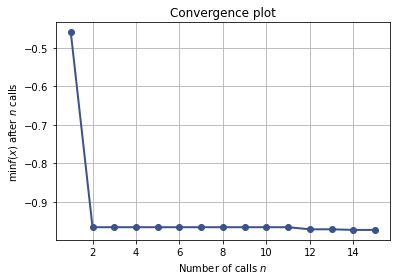

In [17]:
plot_convergence(search_result)

In [18]:
# Find the best Hyper-Parameters
search_result.x

[0.0015747072834881764, 2, 512, 'relu']

In [19]:
def point_to_dict(point):
    return {"lat": point.y, "lng": point.x}

In [20]:
space = search_result.space
#space.point_to_dict(search_result.x)

In [21]:
# This is a negative number because the Bayesian optimizer performs minimization
search_result.fun

-0.9724000096321106

In [22]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9724000096321106, [0.0015747072834881764, 2, 512, 'relu']),
 (-0.97079998254776, [0.0022361010928006746, 4, 455, 'relu']),
 (-0.965399980545044, [0.0024774065496879515, 2, 481, 'sigmoid']),
 (-0.9628000259399414, [0.00010400170353586224, 4, 483, 'relu']),
 (-0.9607999920845032, [0.0027378972876382, 5, 416, 'sigmoid']),
 (-0.9598000049591064, [0.0017046407249460091, 3, 466, 'sigmoid']),
 (-0.9556000232696533, [0.003165323660800592, 1, 189, 'sigmoid']),
 (-0.894599974155426, [0.00024476640772413255, 4, 244, 'sigmoid']),
 (-0.7486000061035156, [4.107048799164143e-06, 2, 295, 'relu']),
 (-0.4607999920845032, [6.669072953996571e-05, 3, 66, 'sigmoid']),
 (-0.4596000015735626, [1e-05, 1, 16, 'relu']),
 (-0.3702000081539154, [3.837282873123039e-05, 5, 262, 'sigmoid']),
 (-0.30799999833106995, [3.492814338499371e-06, 1, 37, 'relu']),
 (-0.24459999799728394, [1.8697855860877785e-05, 2, 15, 'relu']),
 (-0.10599999874830246, [3.2601240470145275e-06, 3, 351, 'sigmoid'])]

## Visualization of Hyper-parameter Search

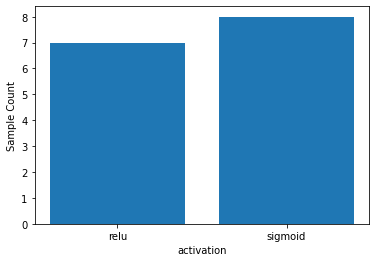

In [23]:
# activation parameter, which shows the distribution of samples during the hyper-parameter optimization.
fig = plot_histogram(result=search_result, dimension_identifier='activation')

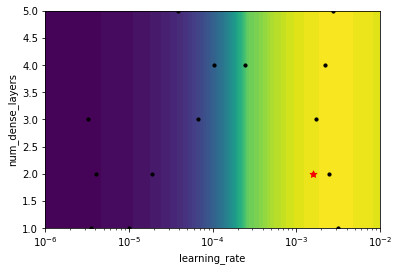

In [24]:
# learning_rate and num_dense_layers
fig = plot_objective_2D(result=search_result, 
                        dimension_identifier1='learning_rate', 
                        dimension_identifier2='num_dense_layers', 
                        levels=50)

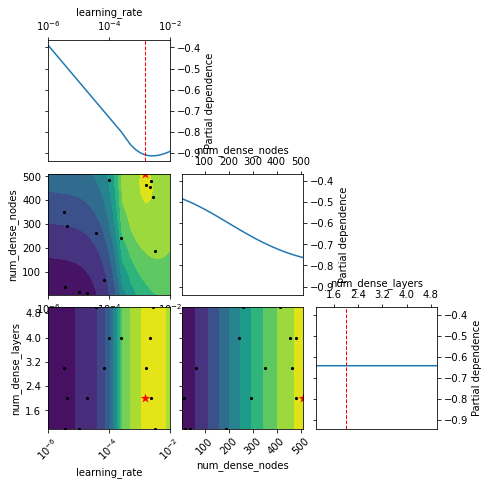

In [25]:
dim_names = ['learning_rate', 'num_dense_nodes', 'num_dense_layers']

fig = plot_objective(result=search_result, plot_dims =dim_names)

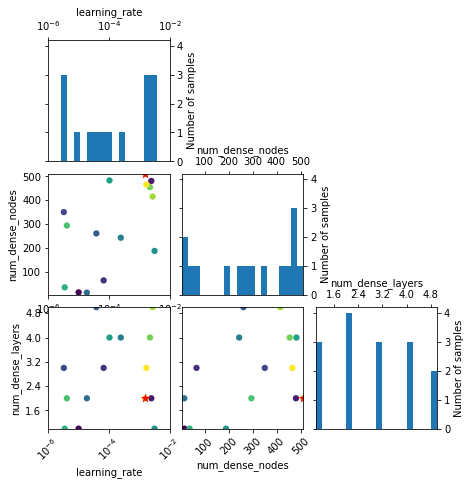

In [26]:
fig = plot_evaluations(result=search_result, plot_dims=dim_names)

## Evaluate Best Model on TestSet

In [27]:
model = load_model(path_best_model)
result = model.evaluate(x=x_test, y=y_test)

469/469 [==============================] - 1s 1ms/step - loss: 0.0905 - accuracy: 0.9735


In [28]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.09048648923635483
accuracy 0.973466694355011


In [29]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

accuracy: 97.35%


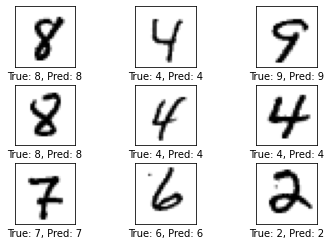

In [30]:
# Visualization of Test results
images = x_test[0:9]
cls_true = y_test_cls[0:9]
y_pred = model.predict(x=images)
cls_pred = np.argmax(y_pred,axis=1)

plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)

In [31]:
t2 = time.time()

In [32]:
t = t2-t1

In [33]:
time.strftime("%H:%M:%S",time.gmtime(t))

'00:01:28'